In [1]:


# Import necessary libraries
import matplotlib.pyplot as plt  # Used for generating various plots and figures.
import numpy as np  # NumPy library for large, multi-dimensional arrays and matrices, along with a large collection of high-level mathematical functions to operate on these arrays.
import cv2  # OpenCV library for handling image and video operations.
from tqdm import trange  # Progress bar utility for loops.
from gymnasium.utils.env_checker import check_env  # Utility function to validate gym environments.
from flygym import Fly, Camera  # Classes from flygym for simulation of a fly and camera visualization.
from flygym.arena import FlatTerrain, OdorArena  # Classes for setting up simulation arenas with different terrains and odor dispersal.
from flygym.examples.turning_controller import HybridTurningNMF  # Simulation controller for managing fly movement decisions.
from pathlib import Path  # Library for easy manipulation of file paths.

# Create directories for outputs if they don't already exist
Path("./outputs/outputs_finaux").mkdir(exist_ok=True)

# Define simulation environment parameters
peak_odor_intensity = np.array([[1, 0], [0, 0], [0, 0]])  # Matrix representing the peak odor intensity at different source points.
odor_source_A = np.array([[-2, 1, 0.2], [-5, -5, 0.2], [-1, 5, 0.2]])  # Array of 3D coordinates for odor sources.

# Define marker colors for visualization
marker_colors = [[255, 127, 14]]  # Initial marker color (orange) in RGB.
marker_colors_A = marker_colors + [[0, 0, 128], [0, 0, 128]]  # Additional marker colors (navy blue) added to the list.
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])  # Convert RGB to RGBA by normalizing and adding alpha value.
marker_colors_A = np.array([[*np.array(color) / 255, 1] for color in marker_colors_A])  # Normalize RGB and add alpha for visualization.

# Instantiate terrain and arena for the simulation
flat_terrain_arena = FlatTerrain()  # Creates a flat terrain arena.
arena = OdorArena(
    odor_source=odor_source_A,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,  # Function to model the diffusion of odor based on distance.
    marker_colors=marker_colors_A,
    marker_size=0.3  # Size of the visual markers in the simulation.
)

# Sensor placement on the fly
contact_sensor_placements = [
    f"{leg}{segment}"  # Creating sensor identifiers for each leg and segment combination.
    for leg in ["LF", "LM", "LH", "RF", "RM", "RH"]
    for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]

# Initialize the Fly object with position, orientation, and sensory capabilities
fly = Fly(
    spawn_pos=(0, 3, 0.2),  # Start position of the fly.
    spawn_orientation=(0, 0, 0),  # Initial orientation (facing forward).
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,  # Olfaction sensors are activated.
    enable_adhesion=True,  # Enables the fly to stick to surfaces.
    draw_adhesion=False  # Adhesion will not be visually represented.
)

# Setup the camera for simulation viewing
cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",  # Identifier for the camera view.
    play_speed=0.2,  # Playback speed for the simulation video.
    window_size=(1000, 608)  # Dimensions of the camera view window.
)

# Configure the simulation with the fly, camera, and arena
sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    arena=arena
)

# Define global parameters for simulation behavior
global white_area_bounds, attractive_gain, aversive_gain, decision_interval, run_time, num_decision_steps, physics_steps_per_decision_step, speed, curr_time, initial_xpos, n_delays
odor_dimensions = len(peak_odor_intensity[0])  # Determine the number of odor dimensions from the peak intensity array.
white_area_bounds = [odor_source_A[1][:2], odor_source_A[2][:2]]  # Area bounds defined by two points for white areas in the arena.
attractive_gain = -500  # Negative gain for attraction behavior.
aversive_gain = 500  # Positive gain for aversive behavior.
decision_interval = 0.05  # Time interval in seconds for each decision step.
run_time = 10  # Total duration of the simulation in seconds.
num_decision_steps = int(run_time / decision_interval)  # Total number of decisions during the simulation.
physics_steps_per_decision_step = int(decision_interval / sim.timestep)  # Number of physics updates per decision step.
speed = 5  # Movement speed for mobile elements in the simulation.
curr_time = 0  # Initialize the current time to zero at the start of the simulation.
initial_xpos = odor_source_A[0][0]  # Starting x-position based on the first odor source.
n_delays = 10  # Number of time steps to delay the signal processing.

# Utility functions to draw and check positions within specified bounds
def draw_white_area_corners(frame, bounds, color=(0, 0, 255), size=5):
    # Draw red corners on the given frame to indicate boundaries.
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    corners = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
    for corner in corners:
        pixel_x = int((corner[0] + 6.75) * 100)  # Calculate pixel x-coordinate.
        pixel_y = int((corner[1] - 0.46) * 100)  # Calculate pixel y-coordinate.
        cv2.circle(frame, (pixel_x, pixel_y), size, color, -1)  # Draw a filled circle at each corner.
    return frame

def is_in_white_area(position, bounds):
    # Check if the given position is within the specified bounds.
    x, y = position[:2]
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    return x1 <= x <= x2 and y1 <= y <= y2  # Return True if within bounds.

# Function to run the simulation with various dynamic elements
def run_simulation(fly_mobile=True, source_mobile=False, bounds=False, white_area_bounds=white_area_bounds, bounds_speed=np.array([[0.03, 0.0], [0.03, 0.0]]), n_delays=n_delays):
    global curr_time, initial_xpos, x_positions, times, obs_hist, odor_history, antennae_positions, O, HRC_model, cheh
    x_positions = []
    times = []
    obs_hist = []
    odor_history = []
    antennae_positions = []
    delayed_intensities = []
    obs, _ = sim.reset()  # Reset the simulation to start conditions.

    attractive_intensities = np.average(
        obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
    )
    aversive_intensities = np.average(
        obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
    )
    O = [attractive_intensities] * n_delays
    HRC_model = []
    p = 0
    xpos = initial_xpos
    xposA = odor_source_A[1][0]
    xposB = odor_source_A[2][0]

    for i in trange(num_decision_steps):
        # Log positions of the antennae at each step
        antennae_pos = sim.physics.bind(fly._antennae_sensors).sensordata
        antennae_pos = antennae_pos.reshape(-1, 3)
        antennae_positions.append(antennae_pos)
        # Update odor intensities if outside the bounds
        if bounds:
            white_area_bounds += bounds_speed
            odor_intensity = arena.get_olfaction(antennae_pos)
            for idx, sensor_pos in enumerate(antennae_pos):
                if not is_in_white_area(sensor_pos, white_area_bounds):
                    odor_intensity[:, idx] = 0
                    obs["odor_intensity"] = odor_intensity.astype(np.float32)

        attractive_intensities = np.average(
            obs["odor_intensity"][0, :].reshape(2, 2), axis=0, weights=[9, 1]
        )
        aversive_intensities = np.average(
            obs["odor_intensity"][1, :].reshape(2, 2), axis=0, weights=[10, 0]
        )

        attractive_intensities[0] = 0 #for making sur only one antenna is valid

        control_signal = np.zeros((2,))

        delayed_intensities = O.pop(0)
        current_intensities = [obs["odor_intensity"][0, :][1], obs["odor_intensity"][0, :][3]]
        O.append(current_intensities)
        HRC_model.append(delayed_intensities[0] * current_intensities[1] - delayed_intensities[1] * current_intensities[0])

        odor_history.append(attractive_intensities + aversive_intensities)
        if source_mobile:
            xpos += 0.03
        if bounds:
            xposA += 0.03
            xposB += 0.03


        for j in range(physics_steps_per_decision_step):
            curr_time += sim.timestep


            times.append(curr_time)
            x_positions.append(xpos)

            if source_mobile:
                sim.physics.bind(marker).mocap_pos[:2] = [xpos, 1]
                arena.odor_source[0, :2] = [xpos, 1]
            if bounds:
                sim.physics.bind(markerA).mocap_pos[:2] = [xposA, -5]
                arena.odor_source[1, :2] = [xposA, -5]
                sim.physics.bind(markerB).mocap_pos[:2] = [xposB, 5]
                arena.odor_source[2, :2] = [xposB, 5]


            obs, _, _, _, _ = sim.step(control_signal)
            rendered_img = sim.render()[0]
            if rendered_img is not None:
                hrc_value = HRC_model[-1] if HRC_model else 0
                im = cv2.putText(
                    rendered_img,
                    f"HRC Model: {hrc_value:.8f}",
                    (100, 50),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1,
                    (0, 0, 0),
                    2,
                    cv2.LINE_AA,
                )
                cam._frames[-1] = im

            obs_hist.append(obs)



In [9]:

run_simulation(fly_mobile=False, source_mobile=False,bounds=True)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [19:53<00:00,  5.97s/it]


In [10]:
x = list(range(num_decision_steps))
#divide x by 100
x = [((i+1)*48) / 200 for i in x]

In [11]:
cam.save_video("./outputs/outputs_finaux/exp_C_2_1.mp4")
#show graph HRC_model through time

[swscaler @ 0x7fed4fd08000] Warning: data is not aligned! This can lead to a speed loss


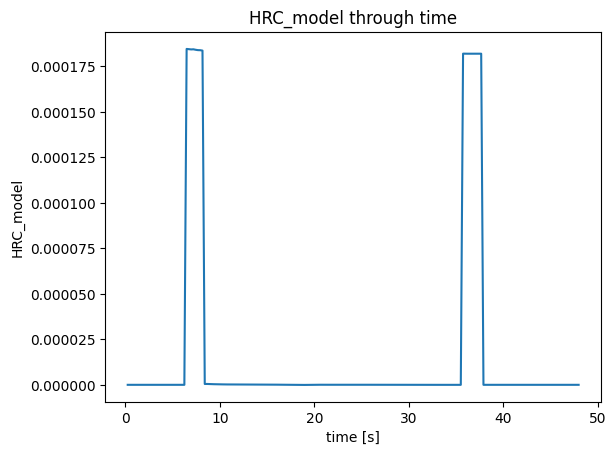

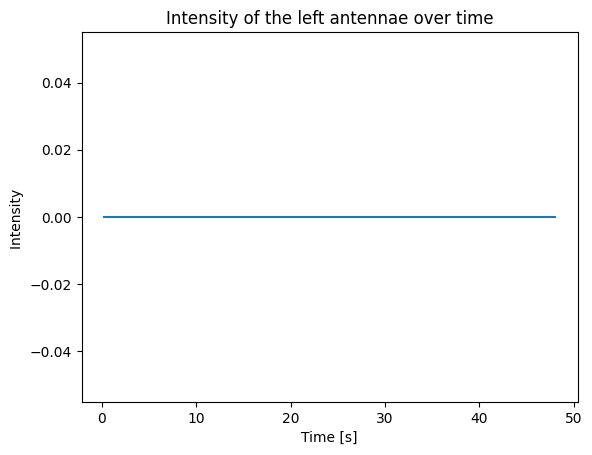

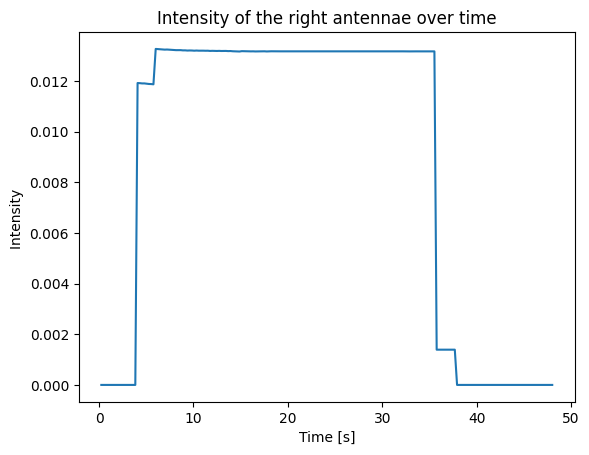

In [12]:

plt.plot(x,HRC_model)
 #change the values of the xlabel

plt.xlabel('time [s]')
plt.ylabel('HRC_model')
plt.title('HRC_model through time')
plt.savefig("./outputs/HRC_exp_C_2_1.png")
plt.show()

#HRC_model

# Extract the first column from odor_history
first_column = [entry[0] for entry in odor_history]

# Plot the first column
plt.plot(x,first_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the left antennae over time')
plt.savefig("./outputs/antenne_1_exp_C_2_1.png")
plt.show()

# Extract the second column from odor_history
second_column = [entry[1] for entry in odor_history]

# Plot the second column
plt.plot(x,second_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the right antennae over time')
plt.savefig("./outputs/antenne_2_exp_C_2_1.png")
plt.show()